In [25]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score


In [26]:
# Load the data from CSV file
df = pd.read_csv("bankruptcy.csv")
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


In [27]:
# Split the data into training and testing sets
X = df.drop("Bankrupt?", axis=1)
y = df["Bankrupt?"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)


### Building a Neural Network Model

This code creates a neural network model using the Keras library with two layers. The first layer is a fully connected (Dense) layer with 64 neurons, which takes an input of shape X_train.shape[1] (the number of features in the training data) and uses the ReLU activation function. The second layer is another Dense layer with a single neuron and uses the sigmoid activation function, which is commonly used for binary classification problems.

In summary, the model has an input layer with the same number of neurons as the number of features in the data, one hidden layer with 64 neurons, and an output layer with a single neuron that outputs a probability between 0 and 1 representing the likelihood of the input belonging to the positive class (bankruptcy in this case).

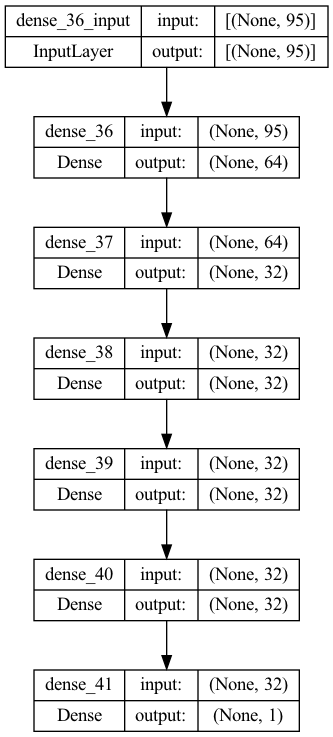

In [28]:
# Build the neural network model
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


# Visualize the model
plot_model(model, to_file='model.png', show_shapes=True)


model.compile is a function in Keras that compiles the model with the chosen loss function, optimizer, and metrics. In this case, the loss function chosen is binary_crossentropy, which is commonly used for binary classification problems. The optimizer chosen is adam, which is a commonly used optimization algorithm for neural networks. Finally, metrics is set to accuracy, which will be used to evaluate the performance of the model during training and testing.

In [29]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


#### This line of code trains the neural network model on the training data with the following parameters:

X_train and y_train: the input features and corresponding target variable used for training the model.
epochs=50: the number of times the model is trained on the entire training dataset.
batch_size=32: the number of samples that will be used in each batch of training.
validation_data=(X_test, y_test): the validation data on which the model will be evaluated after each epoch of training. The validation data is used to monitor the performance of the model on data that it has not seen during training.
During training, the model tries to minimize the binary cross-entropy loss function using the Adam optimizer. The accuracy metric is also computed during training to evaluate the performance of the model on the training data.

In [30]:
# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
171/171 [==============================] - 1s 2ms/step - loss: 2411399.7500 - accuracy: 0.9423 - val_loss: 2043488.6250 - val_accuracy: 0.9648
Epoch 2/50
171/171 [==============================] - 0s 1ms/step - loss: 1037335.9375 - accuracy: 0.9424 - val_loss: 1974095.6250 - val_accuracy: 0.8849
Epoch 3/50
171/171 [==============================] - 0s 1ms/step - loss: 769301.3750 - accuracy: 0.9441 - val_loss: 726400.3125 - val_accuracy: 0.9406
Epoch 4/50
171/171 [==============================] - 0s 1ms/step - loss: 445600.1250 - accuracy: 0.9457 - val_loss: 533207.5625 - val_accuracy: 0.9230
Epoch 5/50
171/171 [==============================] - 0s 1ms/step - loss: 394472.6875 - accuracy: 0.9408 - val_loss: 547237.5000 - val_accuracy: 0.9633
Epoch 6/50
171/171 [==============================] - 0s 1ms/step - loss: 253086.7344 - accuracy: 0.9446 - val_loss: 350084.4375 - val_accuracy: 0.9611
Epoch 7/50
171/171 [==============================] - 0s 1ms/step - loss: 223773.687

### Seeing the accuracy of our CNN model(s)

In [31]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test, y_test)

# Print the accuracy
print("Accuracy:", accuracy)

43/43 [==============================] - 0s 871us/step - loss: 18791.2031 - accuracy: 0.9648
Accuracy: 0.9648093581199646


### Trying to do some visualisation of the data here


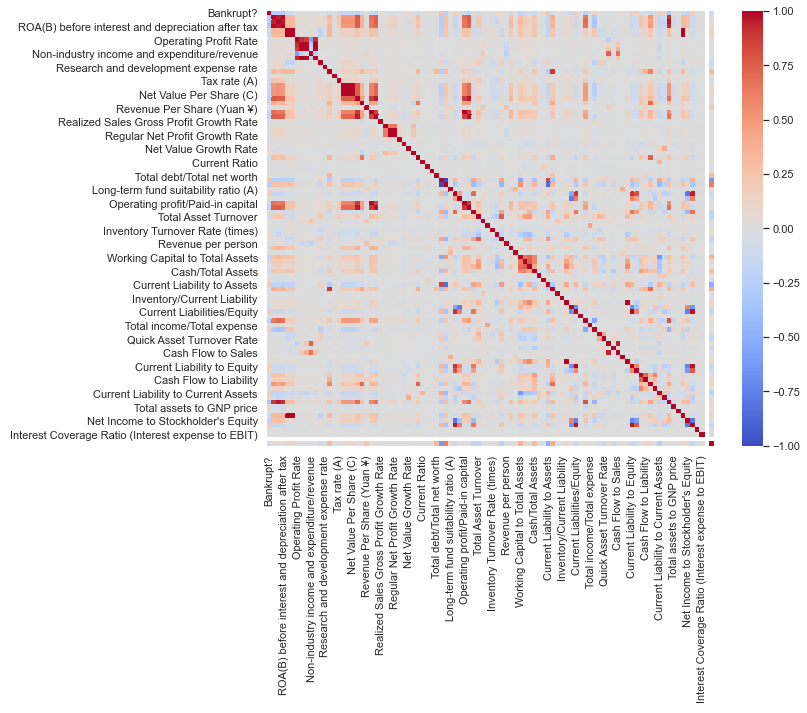

In [32]:
# Create a correlation matrix
corr_matrix = df.corr()

# Generate a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm')

# Show the plot
plt.show()

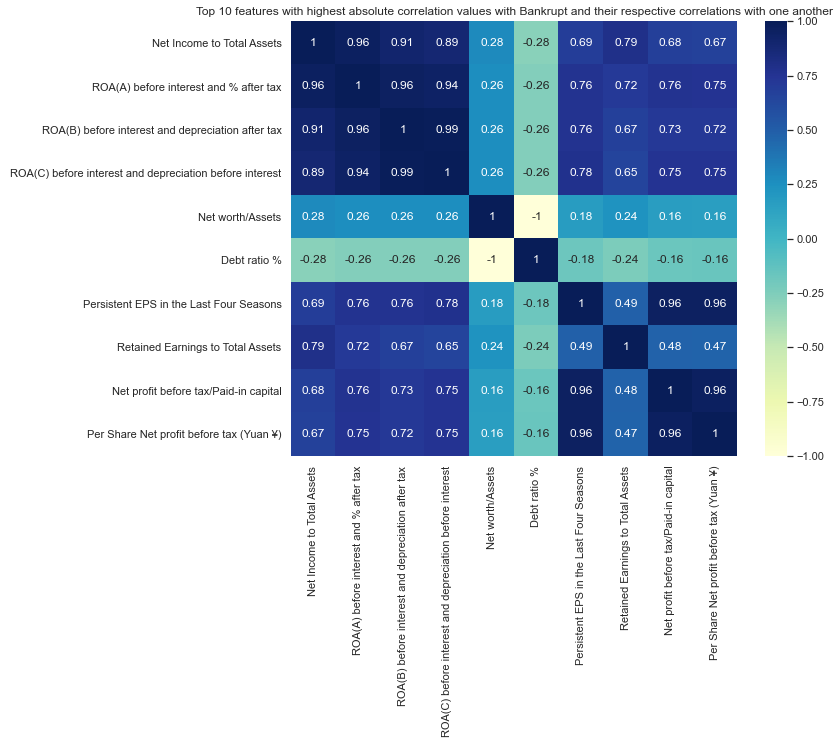

In [33]:
# Find the top 10 features with highest absolute correlation values with Bankrupt? column
num_features = 10
corr_with_bankrupt = corr_matrix["Bankrupt?"].abs().sort_values(ascending=False)
top_corr_features = corr_with_bankrupt[1:num_features+1].index.tolist()

# Create a heatmap of top 10 features with highest absolute correlation values
sns.set(style="white")
plt.figure(figsize=(10,8))
sns.heatmap(df[top_corr_features].corr(), annot=True, cmap="YlGnBu")
plt.title("Top 10 features with highest absolute correlation values with Bankrupt and their respective correlations with one another", fontsize=12)
plt.show()

In [34]:
# Create scatter plot for each combination of top features
# for i in range(len(top_corr_features)):
#     for j in range(i+1, len(top_corr_features)):
#         feature1 = top_corr_features[i]
#         feature2 = top_corr_features[j]
#         sns.jointplot(x=feature1, y=feature2, data=df, kind='reg')
#         plt.show()

### Building a Decision Tree Model

This code trains a decision tree classifier model dectree with a maximum depth of 2 on the training data X_train and y_train.

After training, the model is visualized as a tree using the plot_tree function from sklearn.tree. The plot_tree function generates a tree diagram that shows the decision-making process of the decision tree model.

The filled=True argument fills the tree nodes with colors to indicate the class distribution, while the rounded=True argument makes the edges of the boxes around the nodes rounded.

The feature_names argument specifies the names of the input features or predictors, which are columns in the DataFrame X.

The class_names argument specifies the names of the target classes or outputs, which in this case are "Not Bankrupt" and "Bankrupt".

The resulting tree diagram can be used to interpret how the model makes predictions for new data based on the values of the input features.

[Text(669.6, 1087.2, ' Net Value Growth Rate <= 0.0\ngini = 0.061\nsamples = 5455\nvalue = [5282, 173]\nclass = Not Bankrupt'),
 Text(334.8, 652.32, ' Cash/Total Assets <= 0.01\ngini = 0.482\nsamples = 143\nvalue = [85, 58]\nclass = Not Bankrupt'),
 Text(167.4, 217.44000000000005, 'gini = 0.124\nsamples = 15\nvalue = [1, 14]\nclass = Bankrupt'),
 Text(502.20000000000005, 217.44000000000005, 'gini = 0.451\nsamples = 128\nvalue = [84, 44]\nclass = Not Bankrupt'),
 Text(1004.4000000000001, 652.32, ' Borrowing dependency <= 0.379\ngini = 0.042\nsamples = 5312\nvalue = [5197, 115]\nclass = Not Bankrupt'),
 Text(837.0, 217.44000000000005, 'gini = 0.015\nsamples = 4634\nvalue = [4598, 36]\nclass = Not Bankrupt'),
 Text(1171.8, 217.44000000000005, 'gini = 0.206\nsamples = 678\nvalue = [599, 79]\nclass = Not Bankrupt')]

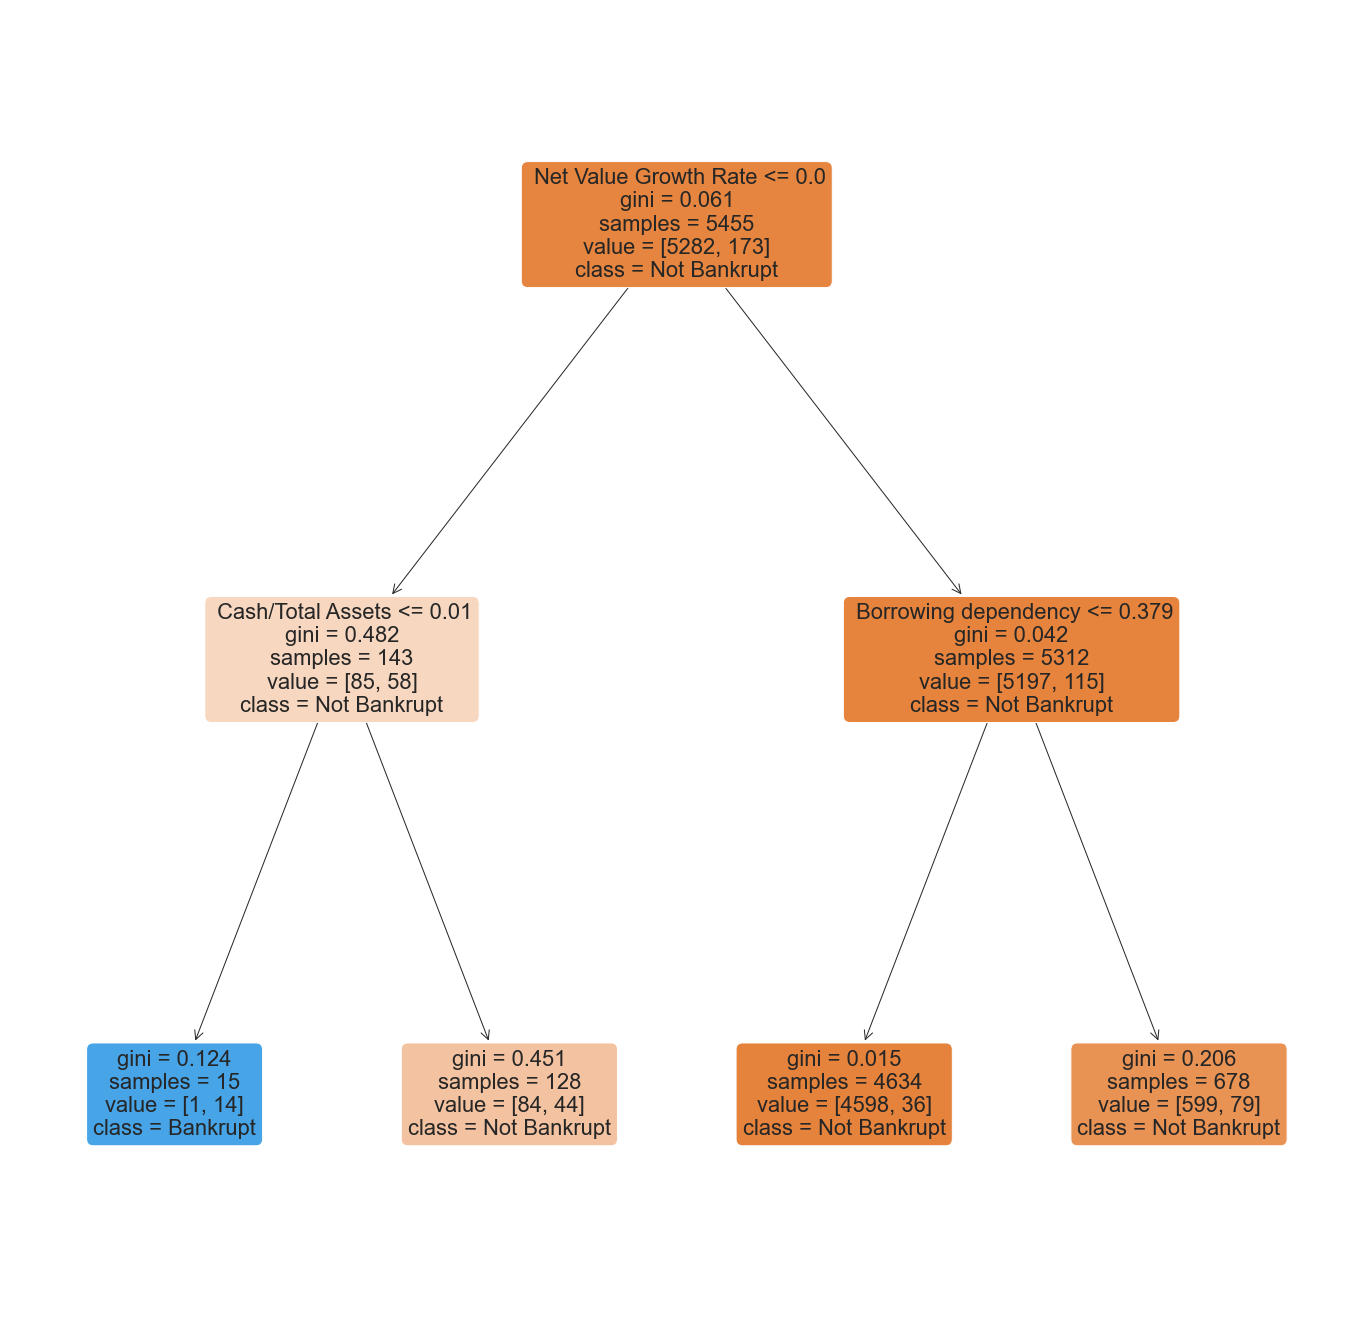

In [35]:
dectree = DecisionTreeClassifier(max_depth=2)
dectree.fit(X_train, y_train)

f = plt.figure(figsize=(24,24))
plot_tree(dectree, filled=True, rounded=True, 
          feature_names=X.columns, 
          class_names=["Not Bankrupt","Bankrupt"])

### Seeing the accuracy of our Decision Tree Model

In [36]:
# Evaluate the accuracy of the model
y_pred = dectree.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of the model: {:.2f}%".format(accuracy*100))


Accuracy of the model: 96.77%
